#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import plotly.express as px
import warnings
warnings.simplefilter('ignore')

#### Loading the data

In [2]:
df = pd.read_csv("/Users/yaminiane/Documents/Projects/ML/Customer_endtoend/Data/Churn_Modelling.csv")

#### Understanding the data

In [3]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender   Age  \
0          1    15634602  Hargrave          619    France  Female  42.0   
1          2    15647311      Hill          608     Spain  Female  41.0   
2          3    15619304      Onio          502    France  Female  42.0   
3          4    15701354      Boni          699    France  Female  39.0   
4          5    15737888  Mitchell          850     Spain  Female  43.0   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1        1.0             1.0   
1       1   83807.86              1        0.0             1.0   
2       8  159660.80              3        1.0             0.0   
3       1       0.00              2        0.0             0.0   
4       2  125510.82              1        NaN             1.0   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [4]:
df.rename(columns = {'Exited':'Churn'}, inplace= True)

In [5]:
df.shape

(10002, 14)

In [6]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Churn'],
      dtype='object')

In [7]:
df.drop(["RowNumber"], axis=1, inplace= True)

In [8]:
df.drop(["CustomerId"], axis=1, inplace= True)

In [9]:
df.drop(["Surname"], axis=1, inplace= True)

#### Data Cleaning

##### Checking for Missing Values

In [10]:
df.isnull().sum()

CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Churn              0
dtype: int64

##### Filling Null Values

In [11]:
geography_mode = df['Geography'].mode()[0]
print(geography_mode)
df["Geography"] = df["Geography"].fillna(geography_mode)

France


In [12]:
age_mean= df['Age'].mean()
df["Age"] = df["Age"].fillna(age_mean)

In [13]:
crcard_mode = df['HasCrCard'].mode()[0]
df["HasCrCard"] = df["HasCrCard"].fillna(crcard_mode)

In [14]:
active_mode = df['IsActiveMember'].mode()[0]
df["IsActiveMember"] = df["IsActiveMember"].fillna(active_mode)

In [15]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Churn              0
dtype: int64

##### Data Distributions

In [16]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Churn                int64
dtype: object

--- Age ---

In [17]:
df['Age']= df['Age'].astype('int')

<Axes: xlabel='Age', ylabel='Density'>

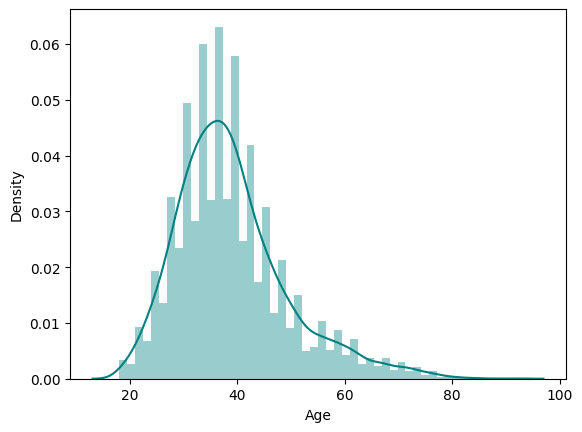

In [18]:
sns.distplot(df["Age"], color = '#008080')

<Axes: xlabel='CreditScore', ylabel='Density'>

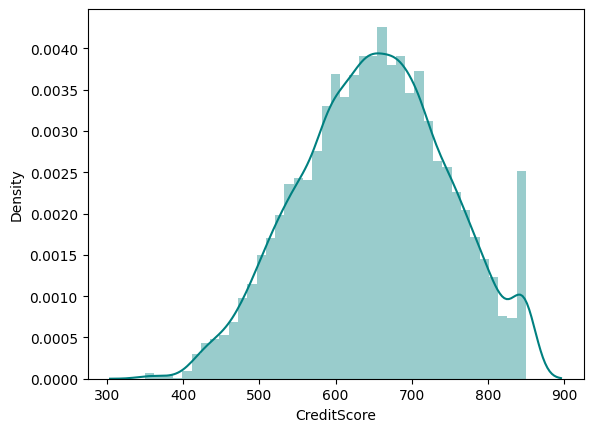

In [19]:
sns.distplot(df["CreditScore"], color = '#008080')

<Axes: xlabel='Tenure', ylabel='Density'>

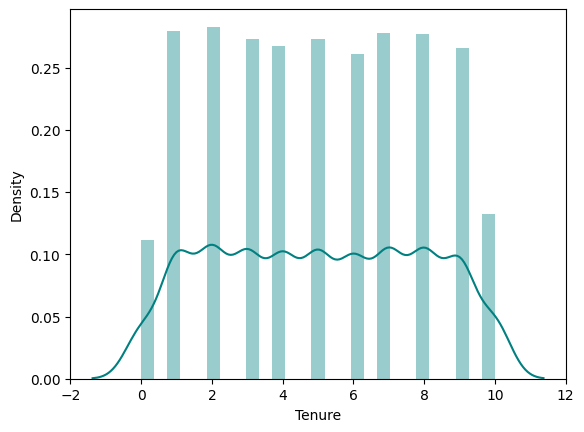

In [20]:
sns.distplot(df['Tenure'], color = '#008080')

<Axes: xlabel='Balance', ylabel='Density'>

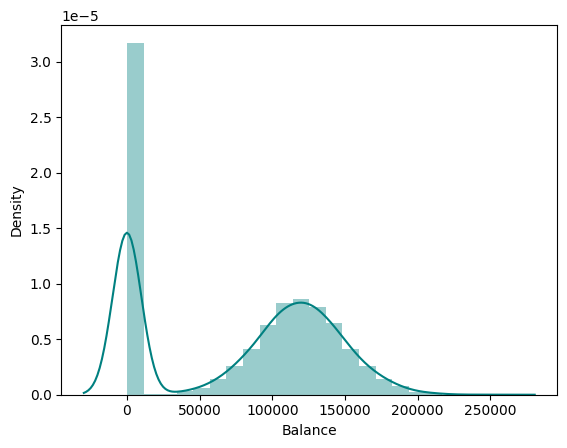

In [21]:
sns.distplot(df['Balance'], color = '#008080')

<Axes: xlabel='EstimatedSalary', ylabel='Density'>

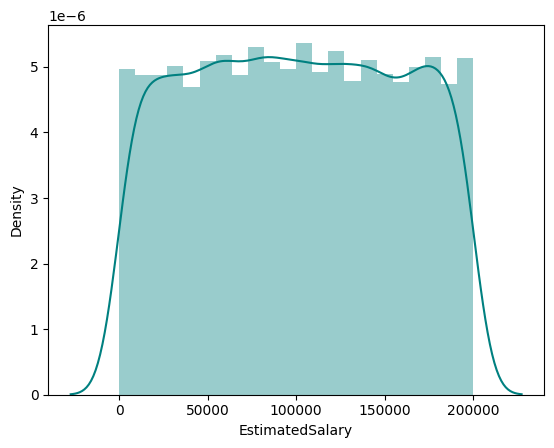

In [22]:
sns.distplot(df['EstimatedSalary'], color = '#008080')

Text(0.5, 1.0, 'Age Distribution of Churned and Non-Churned Customers')

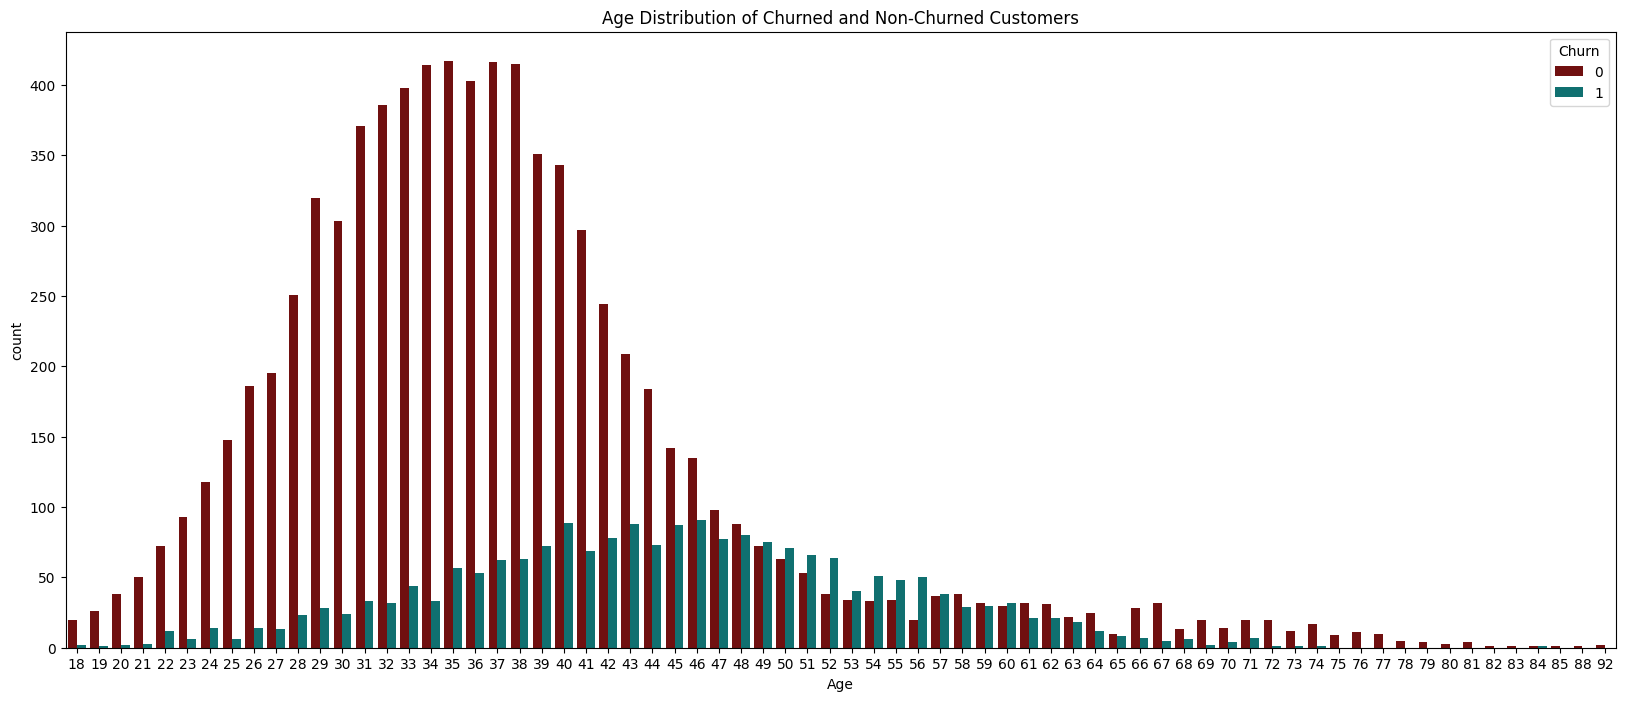

In [23]:
colors = [ '#800000', '#008080']
plt.figure(figsize=(20,8))
sns.countplot( x=df['Age'], hue=df['Churn'], palette=colors)
plt.title("Age Distribution of Churned and Non-Churned Customers")

<Axes: xlabel='Churn', ylabel='Age'>

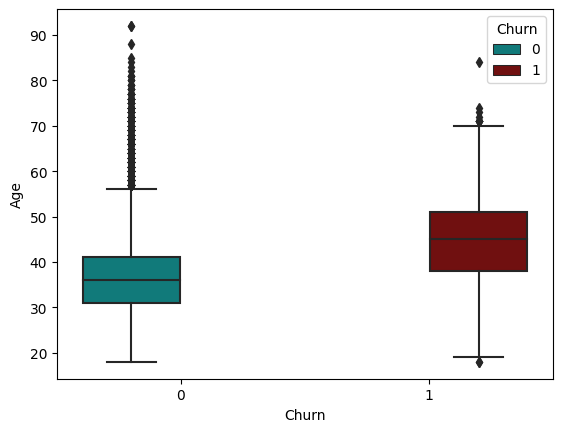

In [24]:
colors = [ 'darkcyan','maroon']
sns.boxplot(x=df['Churn'], y=df['Age'], hue=df['Churn'], palette=colors)

Churned Customers:
The average age of those who have churned from the bank is between 40-50 and extends upto 70.<br>

Non-Churned Customers:
Loyal customers to the bank are concentrated within the age group of 30-40 and there are also lot of customers who are above the age of 60 and are still using the bank's services meaning that senior citizens generally do not churn
<br>
<br>

In [25]:
avg_age_churn = df.groupby("Churn")['Age'].mean()

In [26]:
avg_age_churn

Churn
0    37.408589
1    44.836605
Name: Age, dtype: float64

--- Gender ---

Text(0, 0.5, 'No. of customers')

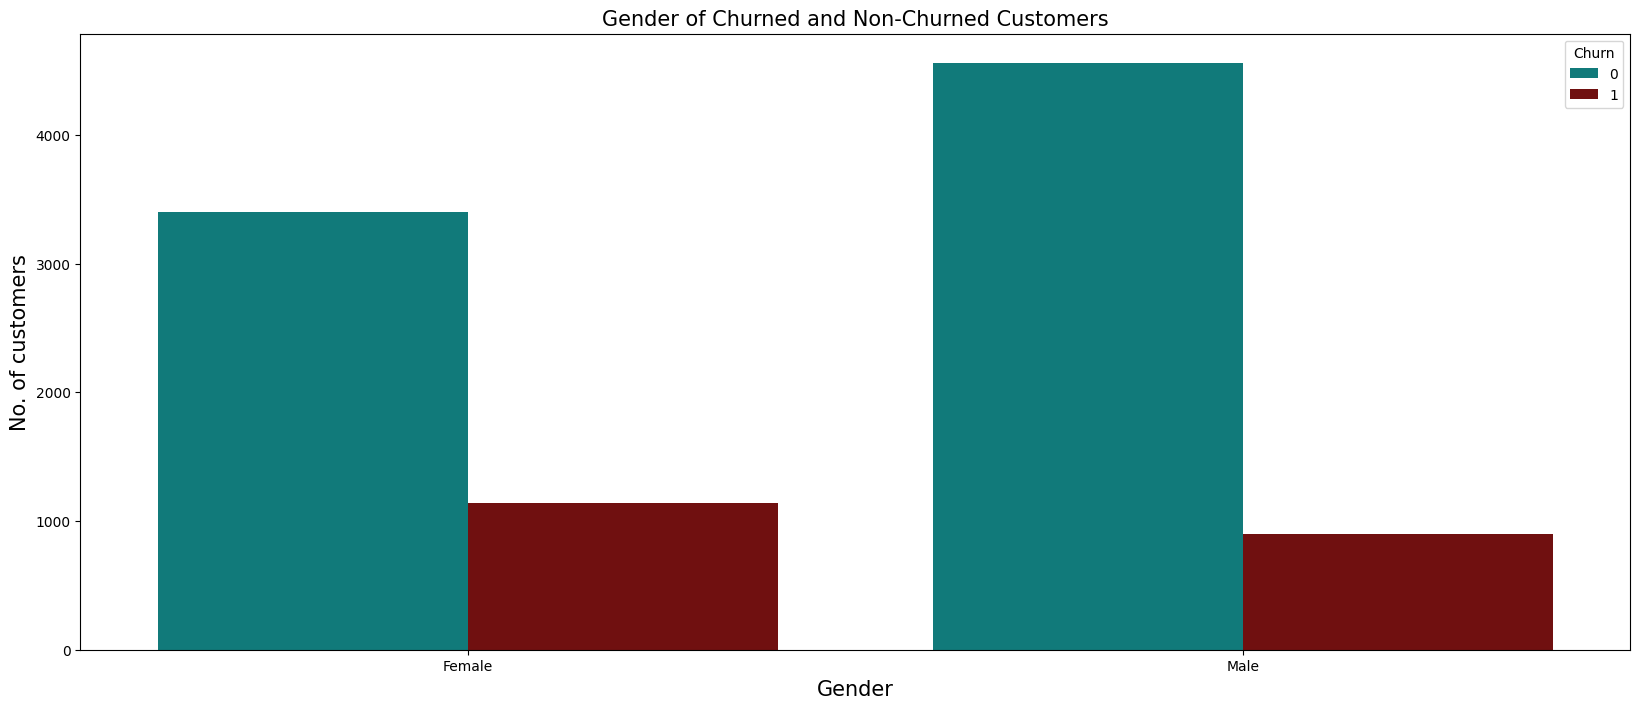

In [27]:
plt.figure(figsize=(20,8))
sns.countplot(x='Gender', hue='Churn', data=df, palette=colors)
plt.title("Gender of Churned and Non-Churned Customers", size=15)
plt.xlabel('Gender',size=15)
plt.ylabel('No. of customers',size=15)

In [28]:
gender_counts = df.groupby('Gender')['Churn'].value_counts().unstack().fillna(0)
gender_counts.columns = ['Retained', 'Churned']
gender_counts['Churn Rate'] = gender_counts['Churned'] / (gender_counts['Retained'] + gender_counts['Churned'])
gender_counts['Retention Rate'] = gender_counts['Retained'] / (gender_counts['Retained'] + gender_counts['Churned'])
rates = gender_counts[['Churn Rate', 'Retention Rate']]
print(rates)

        Churn Rate  Retention Rate
Gender                            
Female    0.250660        0.749340
Male      0.164712        0.835288


--- Credit Score ---

Binning to distribute the credit score

In [29]:
def assign_bins(credit_score):
    if credit_score < 500:
        return '0-499'
    elif 500 <= credit_score < 600:
        return '500-599'
    elif 600 <= credit_score < 700:
        return '600-699'
    elif 700 <= credit_score < 800:
        return '700-799'
    elif 800 <= credit_score < 900:
        return '800-899'
    else:
        return '900-1000'

df['CreditScoreBins'] = df['CreditScore'].apply(assign_bins)

Text(0, 0.5, 'No. of customers')

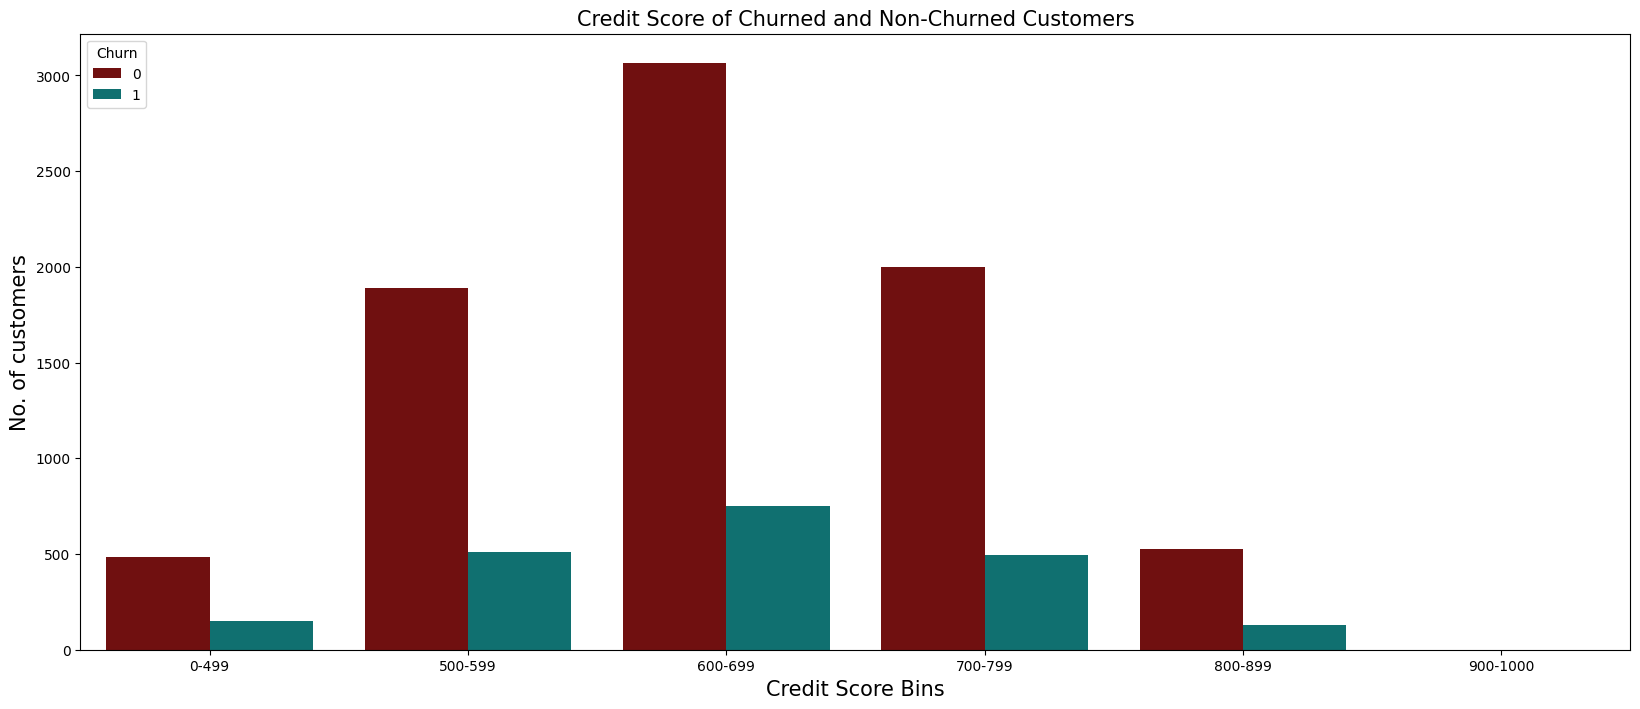

In [30]:
colors = [ '#800000', '#008080']
bin_labels = ['0-499', '500-599', '600-699', '700-799', '800-899', '900-1000']
plt.figure(figsize=(20,8))
sns.countplot( x=df['CreditScoreBins'], hue=df['Churn'], palette=colors, order = bin_labels)
plt.title("Credit Score of Churned and Non-Churned Customers", size =15)
plt.xlabel('Credit Score Bins', size =15)
plt.ylabel('No. of customers', size =15)

In [31]:
df['CreditScoreBins'].value_counts()

CreditScoreBins
600-699    3818
700-799    2495
500-599    2402
800-899     655
0-499       632
Name: count, dtype: int64

In [32]:
df['CreditScore'].mean()

650.5550889822035

<Axes: xlabel='Churn', ylabel='CreditScore'>

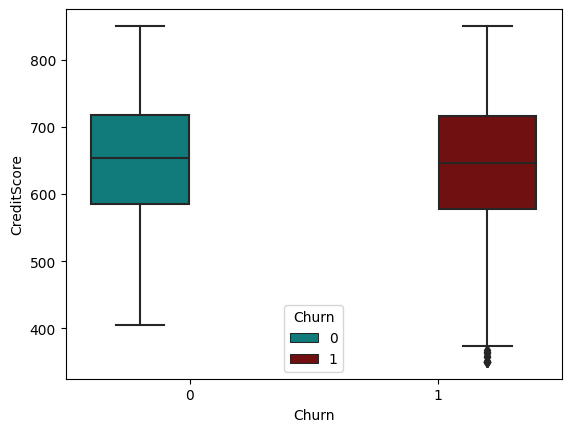

In [33]:
colors = [ 'darkcyan','maroon']
sns.boxplot(x=df['Churn'], y=df['CreditScore'], hue=df['Churn'], palette=colors)

In [34]:
g = df.groupby('Churn')['CreditScore'].agg(['mean','max','min'])
g

mean  max  min
Churn                      
0      651.870794  850  405
1      645.413641  850  350

In [35]:
avg_creditscore_churn = df.groupby("Churn")['CreditScore'].mean()

In [36]:
avg_creditscore_churn

Churn
0    651.870794
1    645.413641
Name: CreditScore, dtype: float64

--- Estimated Salary ---

In [37]:
def salary_bins(salary):
    if salary < 20000:
        return '0-20K'
    elif 20000 <= salary < 40000:
        return '20K-40K'
    elif 40000 <= salary < 60000:
        return '40K-60K'
    elif 60000 <= salary < 80000:
        return '60K-80K'
    elif 80000 <= salary < 100000:
        return '80K-100K'
    elif 100000 <= salary < 120000:
        return '100K-120K'
    else:
        return '>120K'

In [38]:
df['SalaryBins'] = df['EstimatedSalary'].apply(salary_bins)

Text(0, 0.5, 'No. of customers')

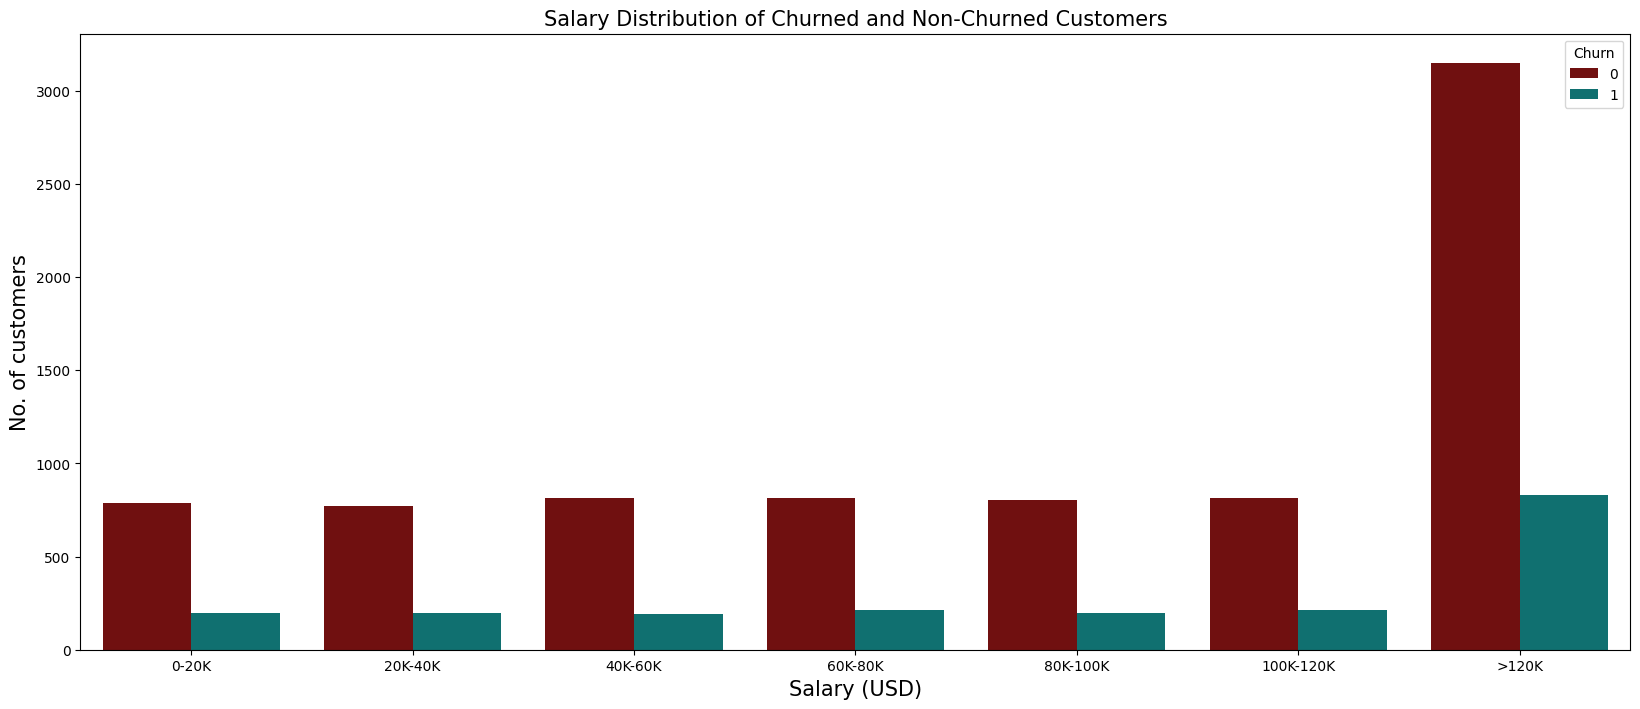

In [39]:
colors = [ '#800000', '#008080']
bin_labels = ['0-20K', '20K-40K', '40K-60K', '60K-80K', '80K-100K', '100K-120K', '>120K']
plt.figure(figsize=(20,8))
sns.countplot( x=df['SalaryBins'], hue=df['Churn'], palette=colors, order=bin_labels)
plt.title("Salary Distribution of Churned and Non-Churned Customers", size =15)
plt.xlabel('Salary (USD)', size =15)
plt.ylabel('No. of customers', size = 15)

In [40]:
salaryPercent= df.groupby(['SalaryBins', 'Churn']).size().unstack().fillna(0)
print(salaryPercent)

Churn          0    1
SalaryBins           
0-20K        788  198
100K-120K    816  211
20K-40K      774  196
40K-60K      815  191
60K-80K      815  212
80K-100K     806  197
>120K       3150  833


In [41]:
salaryPercent['Non Churned Percentage'] = (salaryPercent[0] / (sum((salaryPercent[0]) + salaryPercent[1]))) * 100

In [42]:
salaryPercent['Non Churned Percentage'] = (salaryPercent[0] / (sum(salaryPercent[0]))) * 100

In [43]:
salaryPercent['Non Churned Percentage']

SalaryBins
0-20K         9.894525
100K-120K    10.246107
20K-40K       9.718734
40K-60K      10.233551
60K-80K      10.233551
80K-100K     10.120542
>120K        39.552988
Name: Non Churned Percentage, dtype: float64

In [44]:
salaryPercent['Churned Percentage'] = (salaryPercent[1] / (sum( salaryPercent[1]))) * 100

In [45]:
salaryPercent['Churned Percentage']

SalaryBins
0-20K         9.715407
100K-120K    10.353288
20K-40K       9.617272
40K-60K       9.371933
60K-80K      10.402355
80K-100K      9.666340
>120K        40.873405
Name: Churned Percentage, dtype: float64

Estimated salary of non-churned customers is relatively higher than those who have churned.<br>
40% of the non-churned and churned customers have a salary more than $120K. <br>

<Axes: xlabel='Churn', ylabel='EstimatedSalary'>

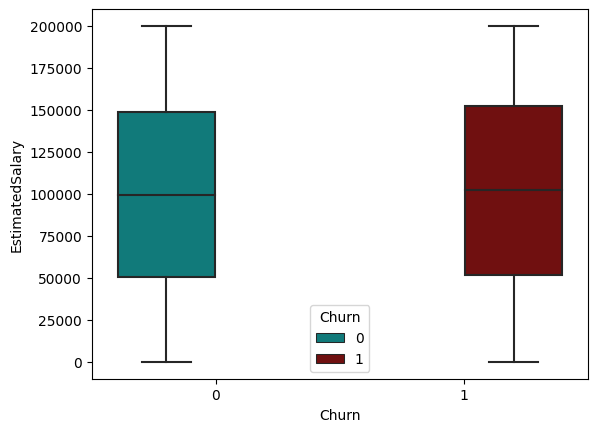

In [46]:
colors = [ 'darkcyan','maroon']
sns.boxplot(x=df['Churn'], y=df['EstimatedSalary'], hue=df['Churn'], palette=colors)

--- Tenure ---

Text(0.5, 1.0, 'Tenure Distribution of Churned and Non-Churned Customers')

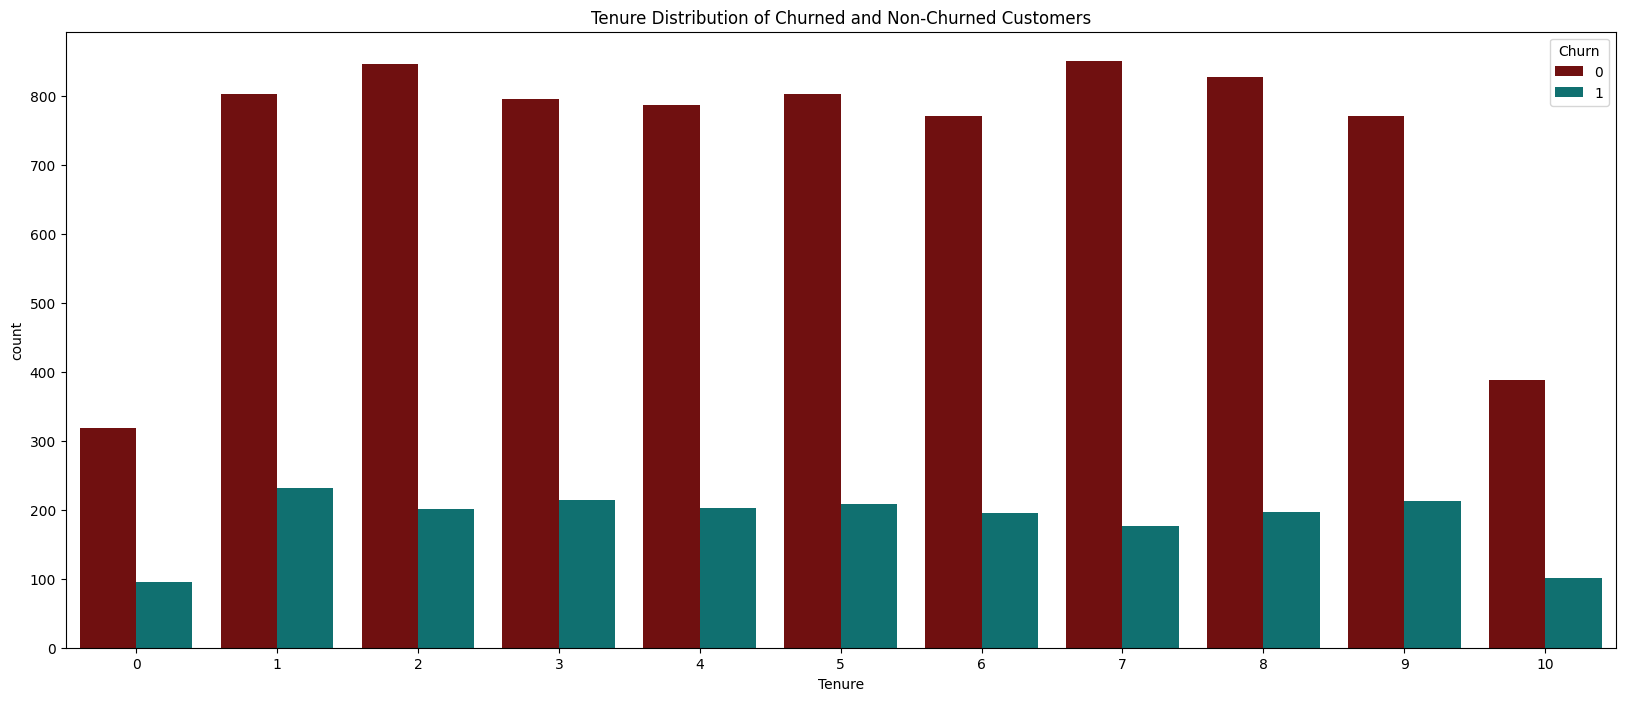

In [47]:
colors = [ '#800000', '#008080']
plt.figure(figsize=(20,8))
sns.countplot( x=df['Tenure'], hue=df['Churn'], palette=colors)
plt.title("Tenure Distribution of Churned and Non-Churned Customers")

<Axes: xlabel='Churn', ylabel='Tenure'>

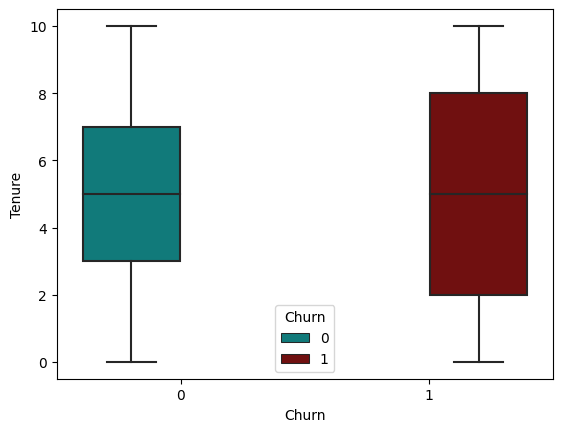

In [48]:
colors = [ 'darkcyan','maroon']
sns.boxplot(x=df['Churn'], y=df['Tenure'], hue=df['Churn'], palette=colors)

Churned customers have used the bank's products and services for a longer period of time (around 6 years) while those who have stayed with the bank have a relatively smaller tenure of 4 years.

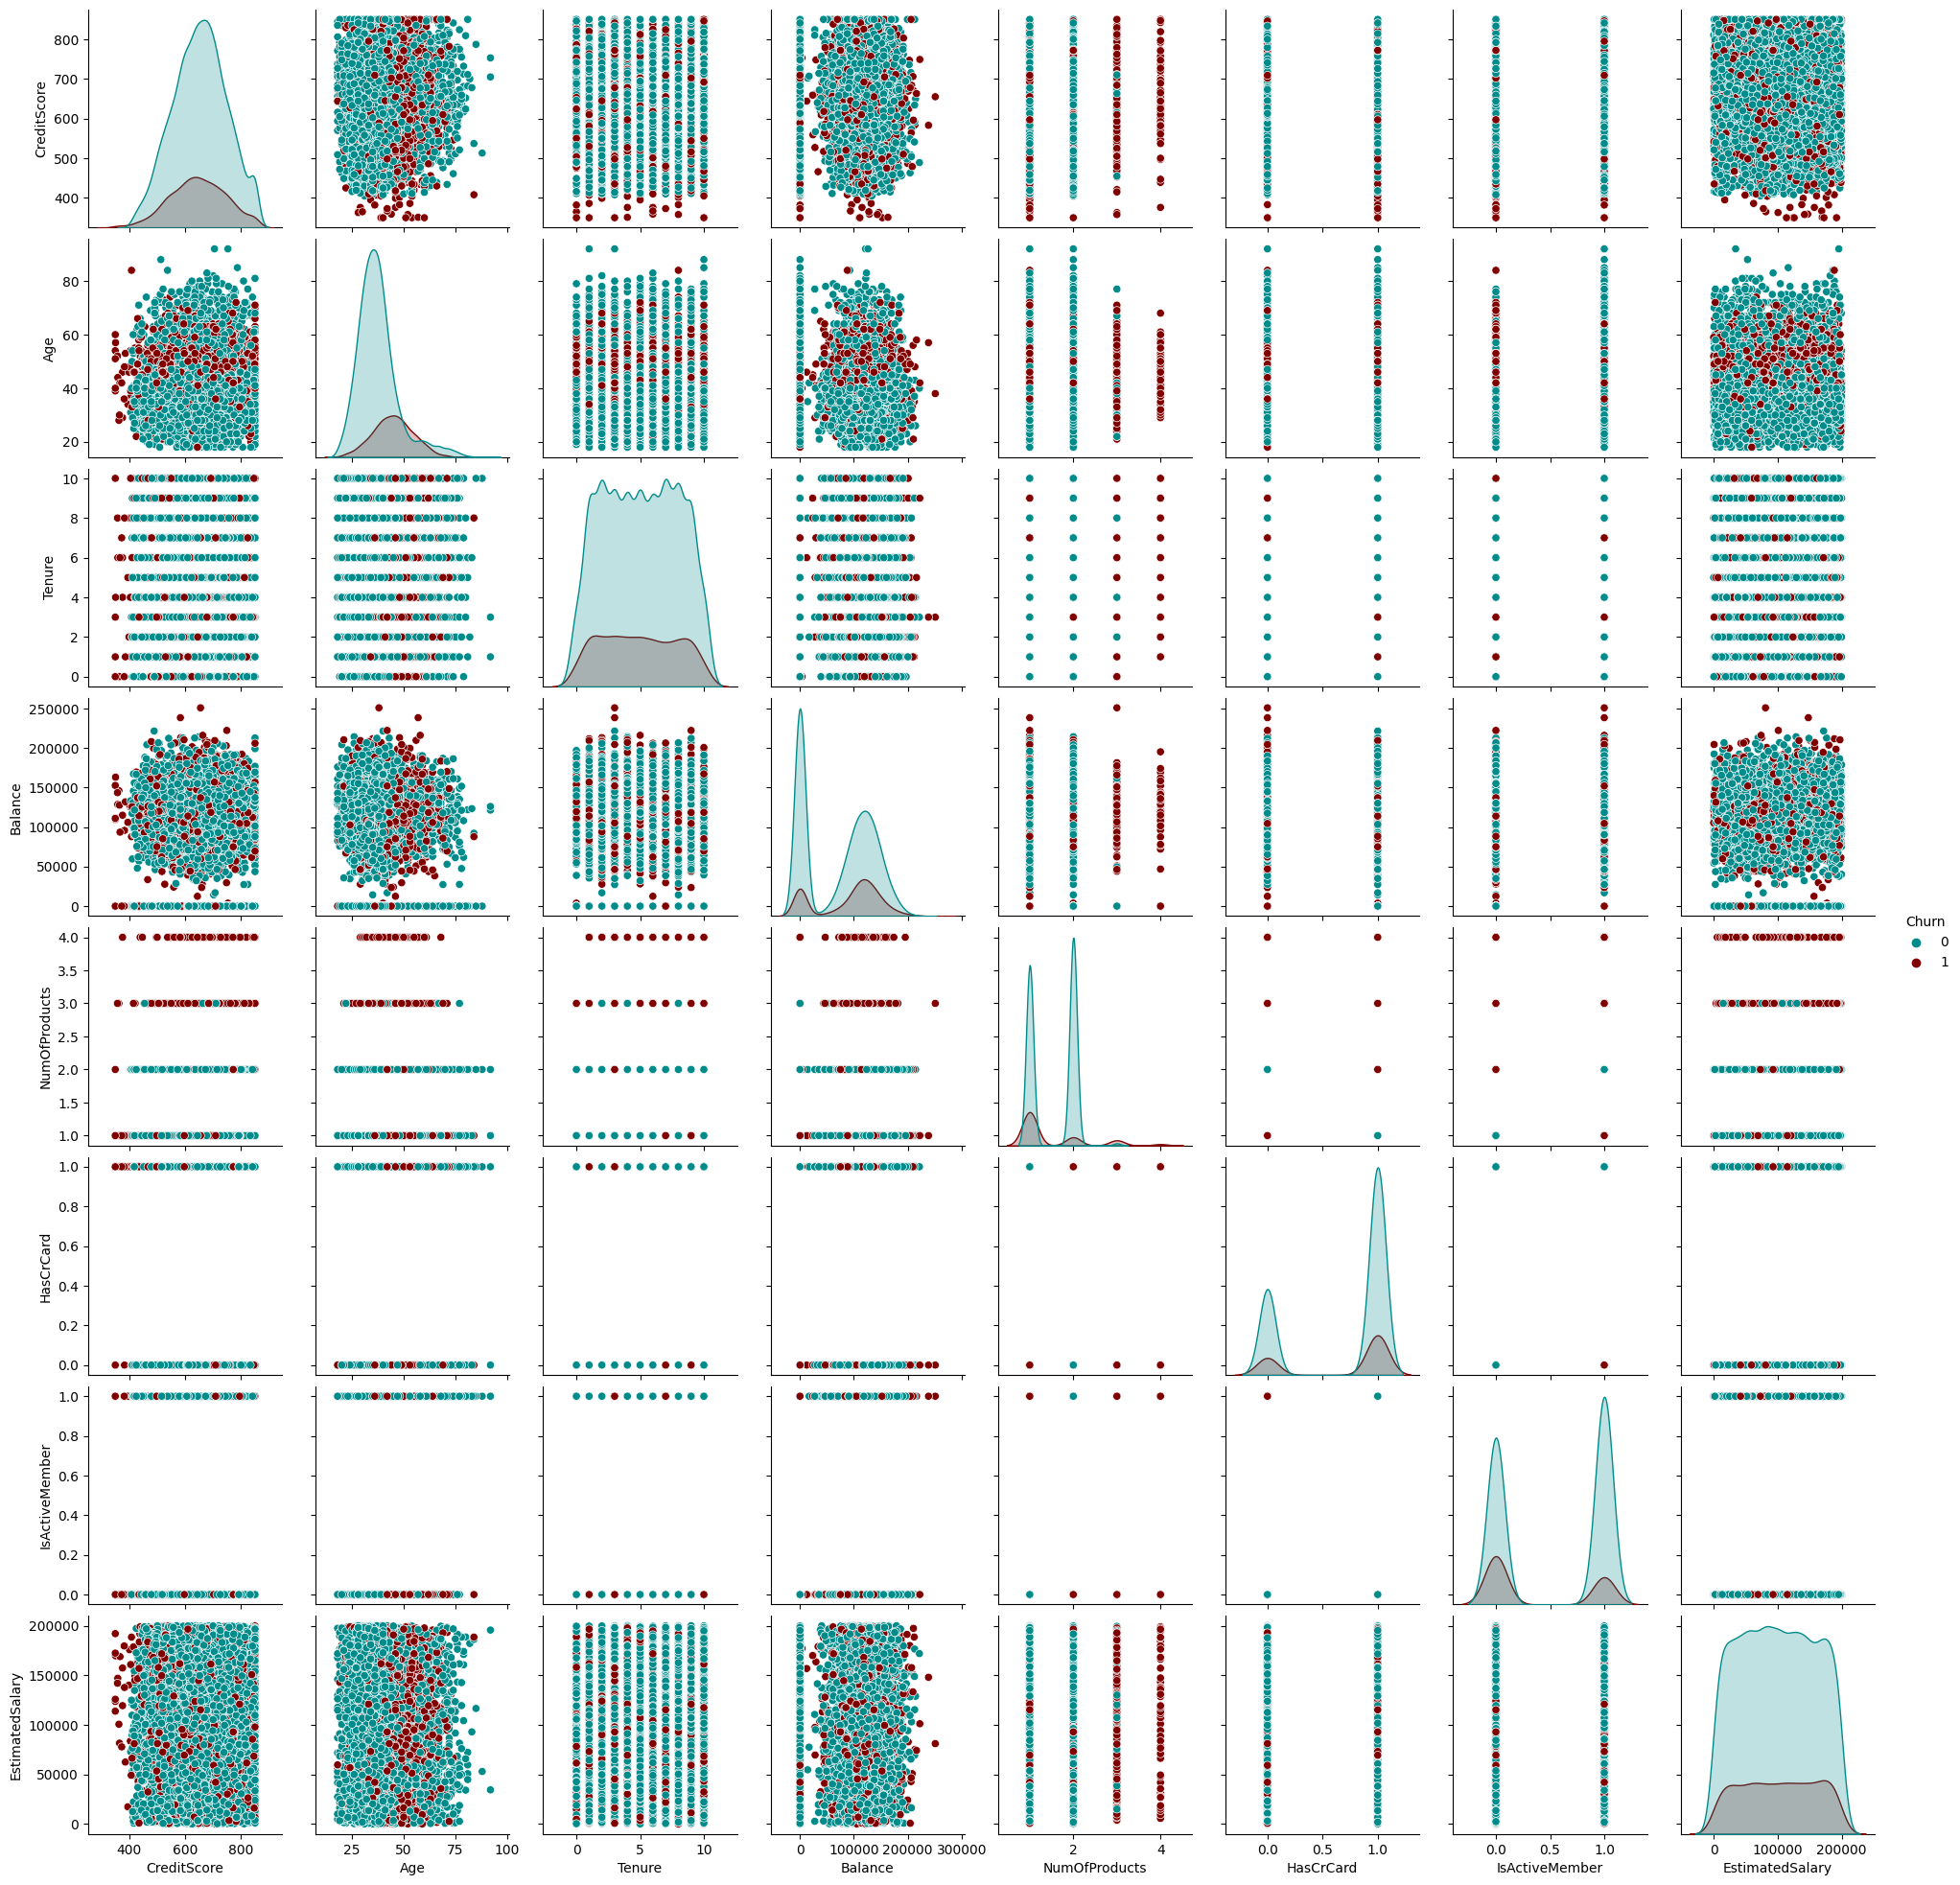

In [49]:
sns.pairplot(df,hue='Churn', palette = colors)

In [50]:
df.groupby('Gender')[['Age', 'EstimatedSalary', 'CreditScore','Balance']].mean()

Age  EstimatedSalary  CreditScore       Balance
Gender                                                       
Female  39.235915     100587.80662   650.862456  75671.359329
Male    38.660865      99663.33544   650.299194  77173.589995

In [51]:
df.groupby('Tenure')[['Age', 'EstimatedSalary', 'CreditScore','Balance']].mean()

Age  EstimatedSalary  CreditScore       Balance
Tenure                                                       
0       39.186441    102374.579128   652.043584  79878.910630
1       39.428986    100468.618957   648.806763  78555.384222
2       39.068702     98312.359857   652.832061  76839.626469
3       39.031683     97662.464921   650.650495  77665.492802
4       38.229293     99805.477828   651.644444  74116.043960
5       39.287549    101286.009644   650.527668  76444.280860
6       38.862461     99168.733154   647.380558  74403.942637
7       38.367704    101257.240370   649.606031  75551.634426
8       38.450732    101072.102937   647.749268  77936.598254
9       39.345528     99416.707022   653.638211  76562.544014
10      39.151020    102805.909224   653.716327  73927.504000

In [52]:
df.groupby('Churn')[['Age', 'EstimatedSalary', 'CreditScore','Balance']].mean()

Age  EstimatedSalary  CreditScore       Balance
Churn                                                       
0      37.408589     99730.663543   651.870794  72752.503898
1      44.836605    101461.468916   645.413641  91100.672198

In [53]:
df.groupby('IsActiveMember')[['Age', 'EstimatedSalary', 'CreditScore','Balance']].mean()

Age  EstimatedSalary  CreditScore       Balance
IsActiveMember                                                       
0.0             37.996702    100752.680023   648.028860  77144.879718
1.0             39.793632     99452.965894   652.934188  75875.422145

In [54]:
df.groupby('HasCrCard')[['Age', 'EstimatedSalary', 'CreditScore','Balance']].mean()

Age  EstimatedSalary  CreditScore       Balance
HasCrCard                                                       
0.0        39.112054    100974.397711   651.345331  77920.787552
1.0        38.842851     99711.474685   650.225308  75894.486558

In [55]:
df.groupby('NumOfProducts')[['Age', 'EstimatedSalary', 'CreditScore','Balance']].mean()

Age  EstimatedSalary  CreditScore       Balance
NumOfProducts                                                       
1              39.672960     99475.202480   649.149066  98558.083184
2              37.754520    100450.365360   652.214768  51884.198342
3              43.195489    104318.130564   648.105263  75458.328195
4              45.683333    104763.723333   653.583333  93733.135000

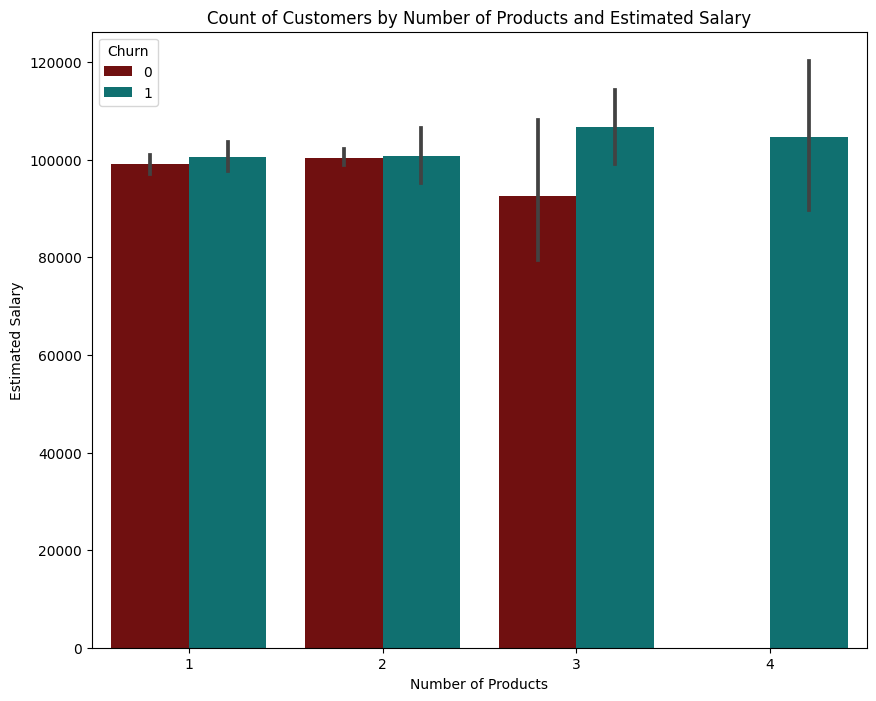

In [56]:
colors = [ '#800000', '#008080']
plt.figure(figsize=(10, 8))
sns.barplot(x='NumOfProducts', y='EstimatedSalary', hue='Churn', data=df, palette=colors)
plt.title('Count of Customers by Number of Products and Estimated Salary')
plt.xlabel('Number of Products')
plt.ylabel('Estimated Salary')
plt.show()

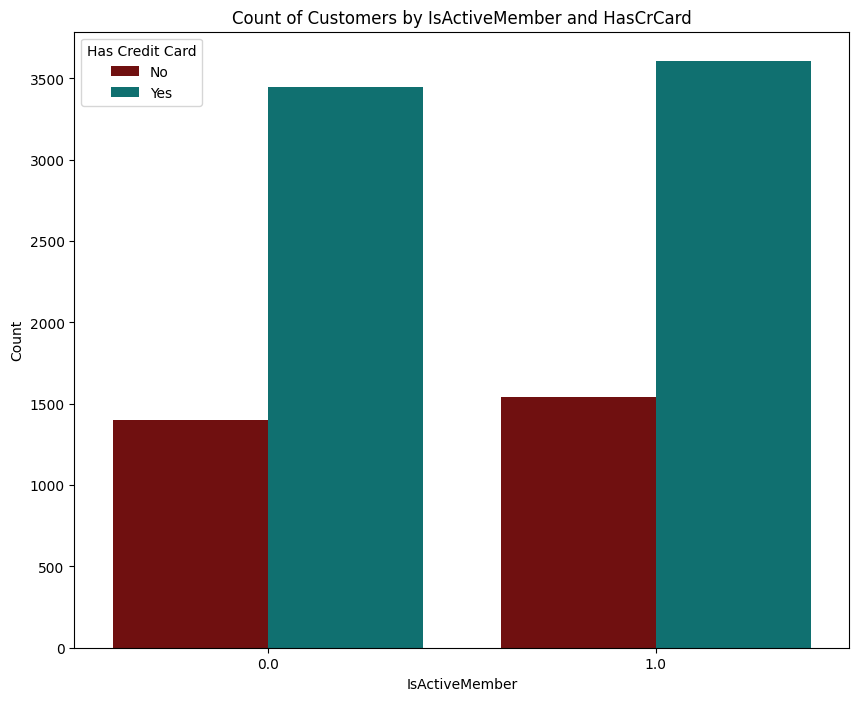

In [57]:
colors = [ '#800000', '#008080']
plt.figure(figsize=(10,8))
sns.countplot(x='IsActiveMember', hue='HasCrCard', data=df, palette= colors)
plt.title('Count of Customers by IsActiveMember and HasCrCard')
plt.xlabel('IsActiveMember')
plt.ylabel('Count')
plt.legend(title='Has Credit Card', labels=['No', 'Yes'])
plt.show()

In [58]:
credit_churned = df.groupby('Churn')['HasCrCard'].value_counts().unstack()

In [59]:
print(credit_churned)

HasCrCard   0.0   1.0
Churn                
0          2332  5632
1           613  1425


In [60]:
churned_with_credit = df[(df['Churn'] == 1) & (df['HasCrCard'] == 1)].shape[0]
total_with_credit = df[df['HasCrCard'] == 1].shape[0]
churned_percent_with_credit = (churned_with_credit / total_with_credit) * 100
print(churned_percent_with_credit)

20.192716451750034


In [61]:
nonchurned_with_credit = df[(df['Churn'] == 0) & (df['HasCrCard'] == 1)].shape[0]
total_credit = df[df['HasCrCard'] == 1].shape[0]
nonchurned_percent_with_credit = (nonchurned_with_credit / total_credit) * 100
print(nonchurned_percent_with_credit)

79.80728354824997


In [62]:
churned_without_credit = df[(df['Churn'] == 1) & (df['HasCrCard'] == 0)].shape[0]
total_noncredit = df[df['HasCrCard'] == 0].shape[0]
churned_percent_without_credit = (churned_without_credit / total_noncredit) * 100
print(churned_percent_without_credit)

20.814940577249573


In [63]:
nonchurned_without_credit = df[(df['Churn'] == 0) & (df['HasCrCard'] == 0)].shape[0]
total_noncredit = df[df['HasCrCard'] == 0].shape[0]
nonchurned_percent_without_credit = (nonchurned_without_credit / total_noncredit) * 100
print(nonchurned_percent_without_credit)

79.18505942275043


There is no significant difference in customer churning depending on whether they have credit card or not.

<Axes: xlabel='Balance', ylabel='CreditScore'>

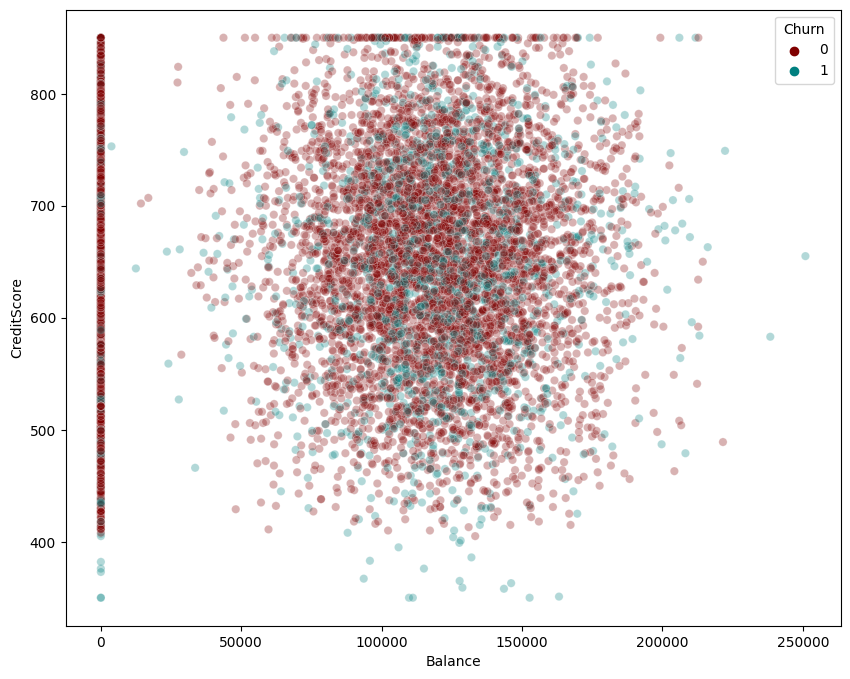

In [64]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='Balance', y = 'CreditScore', hue = "Churn", data =df , palette = colors, alpha =0.3)

In [65]:
products_tenure = df.groupby(['NumOfProducts'])['Tenure'].mean()

In [66]:
products_tenure

NumOfProducts
1    4.974435
2    5.051405
3    5.003759
4    5.300000
Name: Tenure, dtype: float64

In [67]:
df['Tenure'].mean()

5.0124975004999

In [68]:
df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Churn CreditScoreBins  \
0        1.0             1.0        101348.88      1         600-699   
1        0.0             1.0        112542.58      0         600-699   
2        1.0             0.0        113931.57      1         500-599   
3        0.0             0.0         93826.63      0         600-699   
4        1.0             1.0         79084.10      0         800-899   

  SalaryBins  
0  100K-120K  
1  100K-120K  
2  100K-120K  
3   80K-100K  
4    60K-80K

##### Defining the predictor and target variables

In [69]:
X = df.loc[:, ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'CreditScoreBins', 'SalaryBins']]

In [70]:
y = df.loc[:, ['Churn']]

#### Feature Engineering

##### Feature Labeling

In [71]:
X['Geography'].replace({'France':1, "Spain":2, "Germany":3}, inplace = True)

In [72]:
X['CreditScoreBins'].replace({'0-499':1, '500-599':2, '600-699':3, '700-799':4, '800-899':5, '900-1000':6}, inplace = True)

In [73]:
X['SalaryBins'].replace({'0-20K':1, '20K-40K':2, '40K-60K':3, '60K-80K':4, '80K-100K':5, '100K-120K':6, '>120K':7}, inplace = True)

In [74]:
X['Gender'].replace({"Female":0, "Male":1}, inplace= True)

In [75]:
X.head()

CreditScore  Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619          1       0   42       2       0.00              1   
1          608          2       0   41       1   83807.86              1   
2          502          1       0   42       8  159660.80              3   
3          699          1       0   39       1       0.00              2   
4          850          2       0   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  CreditScoreBins  SalaryBins  
0        1.0             1.0        101348.88                3           6  
1        0.0             1.0        112542.58                3           6  
2        1.0             0.0        113931.57                2           6  
3        0.0             0.0         93826.63                3           5  
4        1.0             1.0         79084.10                5           4

##### Data Split

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

##### Feature Scaling

In [77]:
from sklearn.preprocessing import StandardScaler
scalerAge = StandardScaler()
scalerBalance = StandardScaler()
scalerSalary = StandardScaler()

In [78]:
X['Age'] = scalerAge.fit_transform(X[['Age']])

In [79]:
X['Balance'] = scalerBalance.fit_transform(X[['Balance']])

In [80]:
X['EstimatedSalary'] = scalerSalary.fit_transform(X[['EstimatedSalary']])

In [81]:
X.head()

CreditScore  Geography  Gender       Age  Tenure   Balance  NumOfProducts  \
0          619          1       0  0.293518       2 -1.226009              1   
1          608          2       0  0.198155       1  0.117274              1   
2          502          1       0  0.293518       8  1.333054              3   
3          699          1       0  0.007427       1 -1.226009              2   
4          850          2       0  0.388882       2  0.785694              1   

   HasCrCard  IsActiveMember  EstimatedSalary  CreditScoreBins  SalaryBins  
0        1.0             1.0         0.022008                3           6  
1        0.0             1.0         0.216663                3           6  
2        1.0             0.0         0.240817                2           6  
3        0.0             0.0        -0.108802                3           5  
4        1.0             1.0        -0.365171                5           4

In [82]:
X.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'CreditScoreBins', 'SalaryBins'],
      dtype='object')

##### Feature Importance

In [83]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X_train, y_train)

In [84]:
mutual_info

array([0.00203913, 0.01296926, 0.01028915, 0.07298081, 0.        ,
       0.00424735, 0.07335211, 0.00219189, 0.00987718, 0.0011838 ,
       0.        , 0.        ])

These scores indicate the mutual information between each feature and the target variable.<br>
Here are the mutual information scores for each feature:

- CreditScore: 0.0020473
- Geography: 0.0173695
- Gender: 0.00893261
- Age: 0.0696434
- Tenure: 0.00204114
- Balance: 0.00788394
- NumOfProducts: 0.07557507
- HasCrCard: 0.0
- IsActiveMember: 0.01082907
- EstimatedSalary: 0.0011838
- CreditScoreBins: 0.0
- SalaryBins: 0.0


In [85]:
from sklearn.feature_selection import SelectKBest
sel_cols = SelectKBest(mutual_info_classif, k = 10)
sel_cols.fit(X_train, y_train)


SelectKBest(score_func=<function mutual_info_classif at 0x28a949da0>)

In [86]:
selected_features_indices = sel_cols.get_support(indices=True)
selected_features_names = X_train.columns[selected_features_indices]

In [87]:
print("Selected Features:", selected_features_names)

Selected Features: Index(['Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'SalaryBins'],
      dtype='object')


In [88]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_

importance_dict = {feature: importance for feature, importance in zip(X_train.columns, feature_importances)}
sorted_importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))

for feature, importance in sorted_importance_dict.items():
    print(f"{feature}: {importance:.2f}")

Age: 0.23
Balance: 0.13
NumOfProducts: 0.13
EstimatedSalary: 0.13
CreditScore: 0.12
Tenure: 0.07
SalaryBins: 0.04
Geography: 0.04
IsActiveMember: 0.04
CreditScoreBins: 0.03
HasCrCard: 0.02
Gender: 0.02


From mutal_info and the above feature importance, the top 3 features that play a crucial role in determining the target variable:
1. Age
2. Number of Products
3. IsActiveMember

In [89]:
X_train.drop(['CreditScoreBins', 'SalaryBins'], axis=1, inplace=True)
X_test.drop(['CreditScoreBins', 'SalaryBins'], axis=1, inplace=True)

##### Model Building

In [90]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [91]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_dtc_test = dtc.predict(X_test)
y_pred_dtc_train = dtc.predict(X_train)

test_acc_dtc = accuracy_score(y_test, y_pred_dtc_test)
train_acc_dtc = accuracy_score(y_train, y_pred_dtc_train)

print(f'Test Accuracy: {test_acc_dtc:.2f}')
print(f'Train Accuracy: {train_acc_dtc:.2f}')


Test Accuracy: 0.78
Train Accuracy: 1.00


In [127]:
print(classification_report(y_test, y_pred_dtc_test))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1599
           1       0.46      0.54      0.50       402

    accuracy                           0.78      2001
   macro avg       0.67      0.69      0.68      2001
weighted avg       0.80      0.78      0.79      2001



In [92]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [93]:

y_pred_rf_test = rf.predict(X_test)
y_pred_rf_train = rf.predict(X_train)

test_acc_rf = accuracy_score(y_test, y_pred_rf_test)
train_acc_rf = accuracy_score(y_train, y_pred_rf_train)

print(f'Test Accuracy: {test_acc_rf:.2f}')
print(f'Train Accuracy: {train_acc_rf:.2f}')

Test Accuracy: 0.86
Train Accuracy: 1.00


In [129]:
print(classification_report(y_test, y_pred_rf_test))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1599
           1       0.74      0.49      0.59       402

    accuracy                           0.86      2001
   macro avg       0.81      0.72      0.75      2001
weighted avg       0.85      0.86      0.85      2001



In [94]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [95]:
y_pred_xgb_test = xgb.predict(X_test)
y_pred_xgb_train = xgb.predict(X_train)

test_acc_xgb = accuracy_score(y_test, y_pred_xgb_test)
train_acc_xgb = accuracy_score(y_train, y_pred_xgb_train)

print(f'Test Accuracy: {test_acc_xgb:.2f}')
print(f'Train Accuracy: {train_acc_xgb:.2f}')

Test Accuracy: 0.86
Train Accuracy: 0.96


In [130]:
print(classification_report(y_test, y_pred_xgb_test))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1599
           1       0.70      0.54      0.61       402

    accuracy                           0.86      2001
   macro avg       0.79      0.74      0.76      2001
weighted avg       0.85      0.86      0.85      2001



##### Hyperparameter Tuning Using GridSearchCV

In [96]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0, 0.1, 0.2]
}

In [97]:
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

y_pred_best_xgb_test = best_xgb.predict(X_test)
y_pred_best_xgb_train = best_xgb.predict(X_train)

test_acc_best_xgb = accuracy_score(y_test, y_pred_best_xgb_test)
train_acc_best_xgb = accuracy_score(y_train, y_pred_best_xgb_train)

print(f'Test Accuracy: {test_acc_best_xgb:.2f}')
print(f'Train Accuracy: {train_acc_best_xgb:.2f}')

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, m

In [131]:
print(classification_report(y_test, y_pred_best_xgb_test))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1599
           1       0.76      0.50      0.60       402

    accuracy                           0.87      2001
   macro avg       0.82      0.73      0.76      2001
weighted avg       0.86      0.87      0.86      2001



In [98]:
import pickle
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(best_xgb, file)

with open('scaler_age.pkl', 'wb') as file:
    pickle.dump(scalerAge, file)

with open('scaler_balance.pkl', 'wb') as file:
    pickle.dump(scalerBalance, file)

with open('scaler_salary.pkl', 'wb') as file:
    pickle.dump(scalerSalary, file)


# Customer Segmentation

In [99]:
df = pd.read_csv("/Users/yaminiane/Documents/Projects/ML/Customer_endtoend/Data/Churn_Modelling.csv")

In [100]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender   Age  \
0          1    15634602  Hargrave          619    France  Female  42.0   
1          2    15647311      Hill          608     Spain  Female  41.0   
2          3    15619304      Onio          502    France  Female  42.0   
3          4    15701354      Boni          699    France  Female  39.0   
4          5    15737888  Mitchell          850     Spain  Female  43.0   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1        1.0             1.0   
1       1   83807.86              1        0.0             1.0   
2       8  159660.80              3        1.0             0.0   
3       1       0.00              2        0.0             0.0   
4       2  125510.82              1        NaN             1.0   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [101]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [102]:
df.dropna(axis=0, inplace=True)

In [103]:
df.shape

(9998, 14)

In [154]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

selected_columns = ['CreditScore', 'Balance', 'NumOfProducts', 'HasCrCard','IsActiveMember']
segmentation_data = df[selected_columns].copy()
segmentation_data = pd.get_dummies(segmentation_data)

In [155]:
scaler = StandardScaler()
segmentation_data[['CreditScore', 'Balance','NumOfProducts']] = scaler.fit_transform(segmentation_data[['CreditScore', 'Balance','NumOfProducts']])

In [156]:
inertia = []
clusters_range = range(1, 11)
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(segmentation_data)
    inertia.append(kmeans.inertia_)

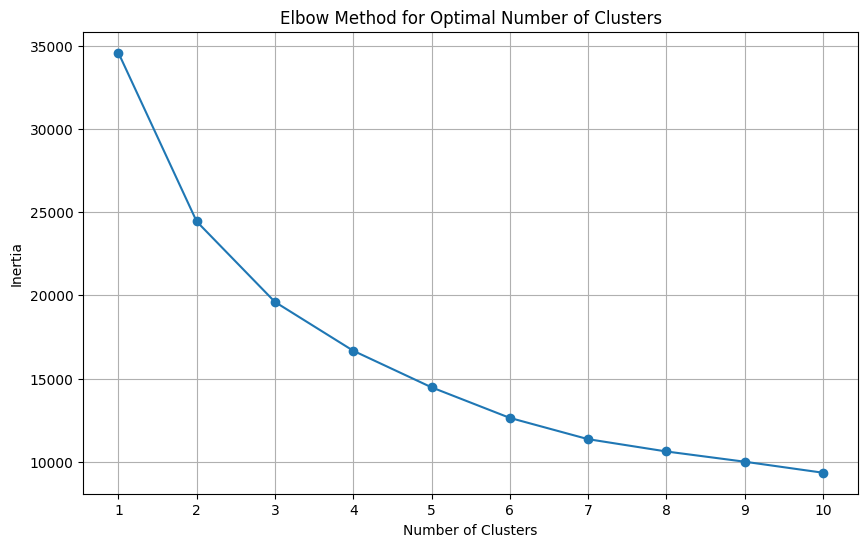

In [157]:
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertia, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(clusters_range)
plt.grid(True)
plt.show()

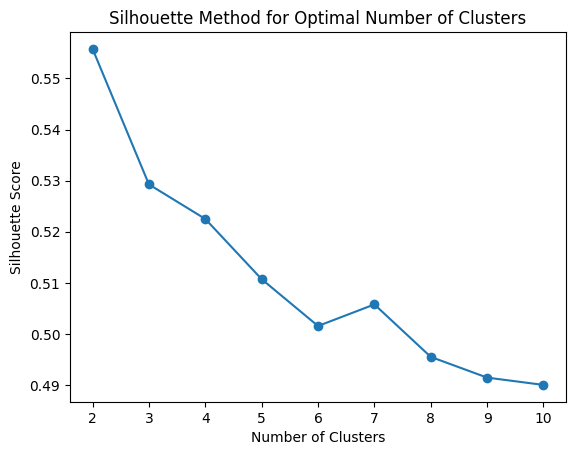

In [158]:
from sklearn.metrics import silhouette_score
k_values = range(2, 11)
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal Number of Clusters')
plt.show()

In [159]:
optimal_clusters = 3

In [161]:
kmeans = KMeans(n_clusters=3, random_state=42)
segmentation_data['Cluster'] = kmeans.fit_predict(segmentation_data)

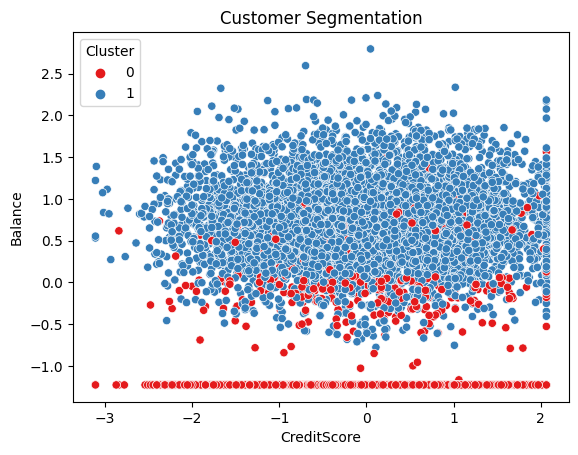

In [153]:
sns.scatterplot(data=segmentation_data, x='CreditScore', y='Balance', hue='Cluster', palette='Set1')
plt.title('Customer Segmentation')
plt.xlabel('CreditScore')
plt.ylabel('Balance')
plt.show()

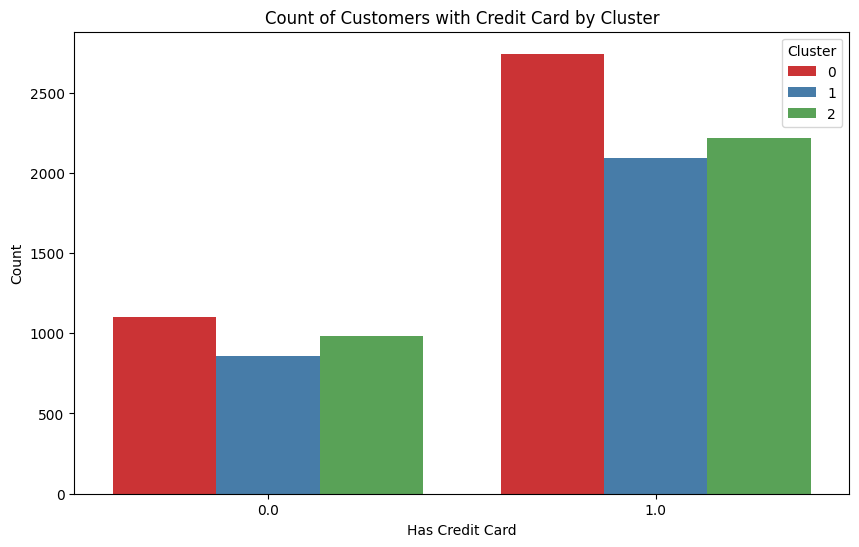

In [144]:
plt.figure(figsize=(10, 6))
sns.countplot(data=segmentation_data, x='HasCrCard', hue='Cluster', palette='Set1')
plt.title('Count of Customers with Credit Card by Cluster')
plt.xlabel('Has Credit Card')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

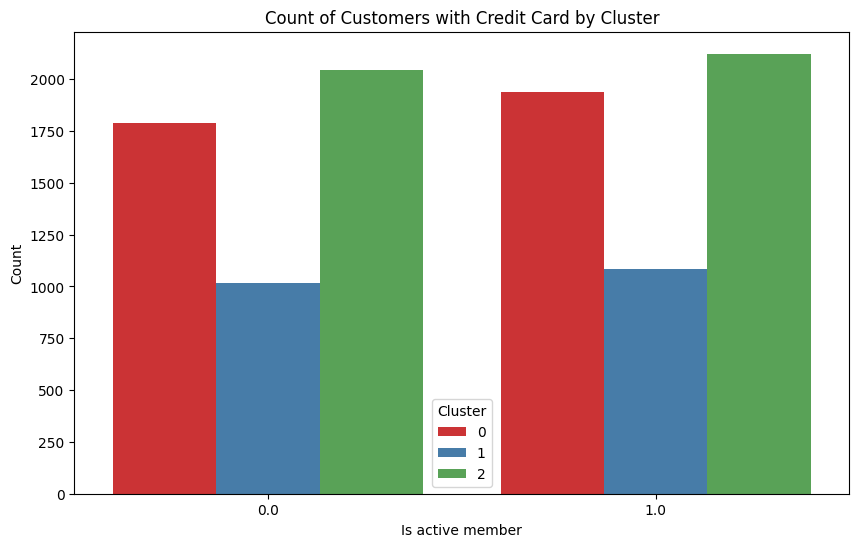

In [162]:
plt.figure(figsize=(10, 6))
sns.countplot(data=segmentation_data, x='IsActiveMember', hue='Cluster', palette='Set1')
plt.title('Count of Customers with Credit Card by Cluster')
plt.xlabel('Is active member')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

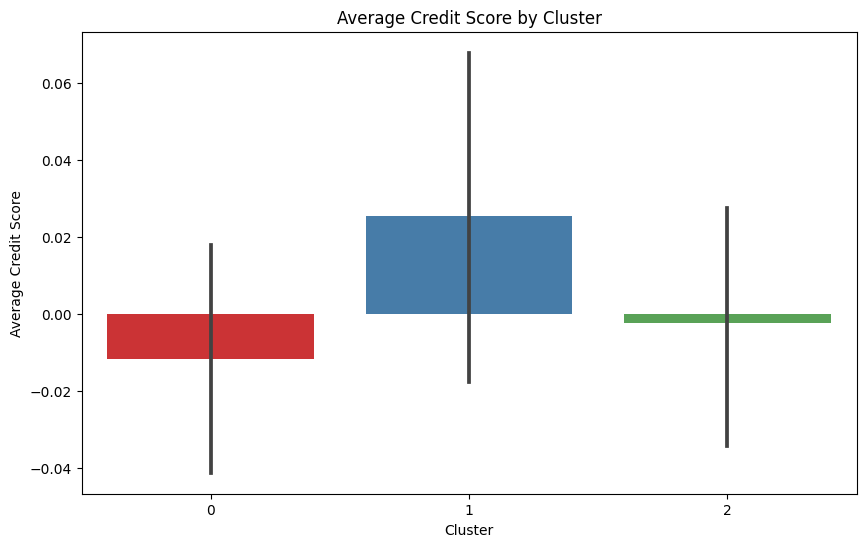

In [163]:
plt.figure(figsize=(10, 6))
sns.barplot(data=segmentation_data, x='Cluster', y='CreditScore', palette='Set1')
plt.title('Average Credit Score by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Credit Score')
plt.show()

In [164]:
cluster_profiles = segmentation_data.groupby('Cluster').mean()
print(cluster_profiles)

         CreditScore   Balance  NumOfProducts  HasCrCard  IsActiveMember
Cluster                                                                 
0          -0.011642 -1.199251       0.443933   0.713596        0.519710
1           0.025423  0.740963       1.020467   0.703475        0.516897
2          -0.002400  0.699435      -0.911570   0.699376        0.509357


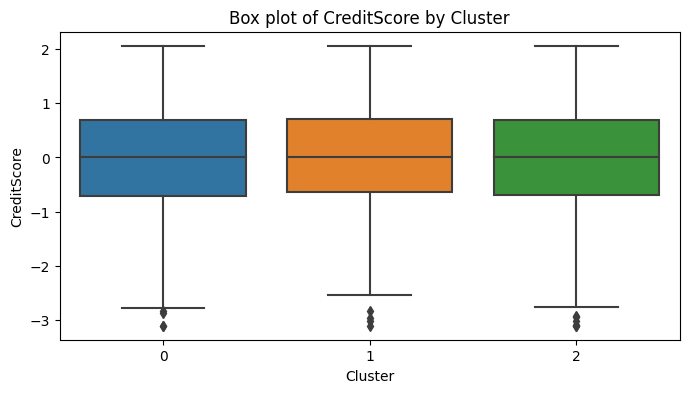

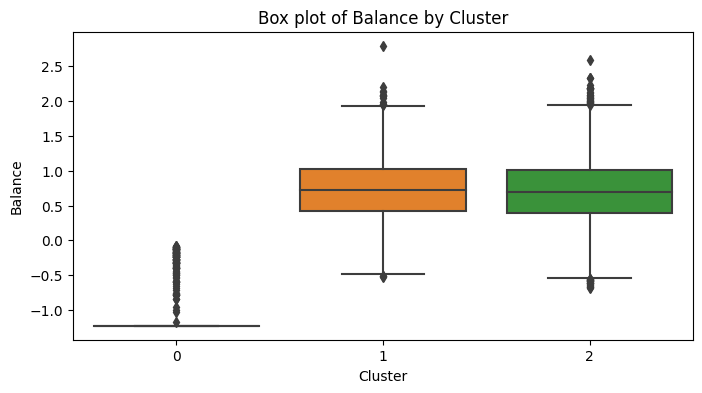

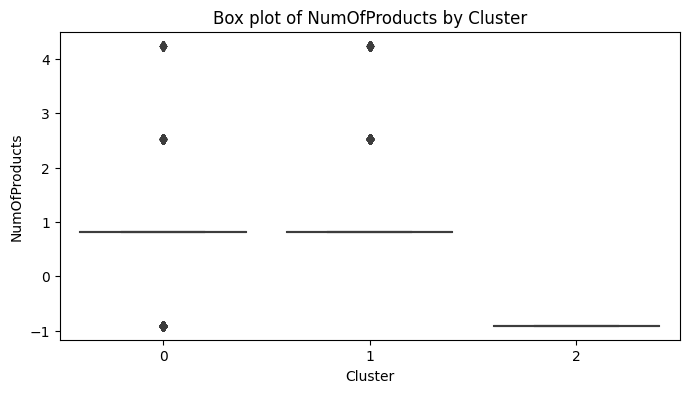

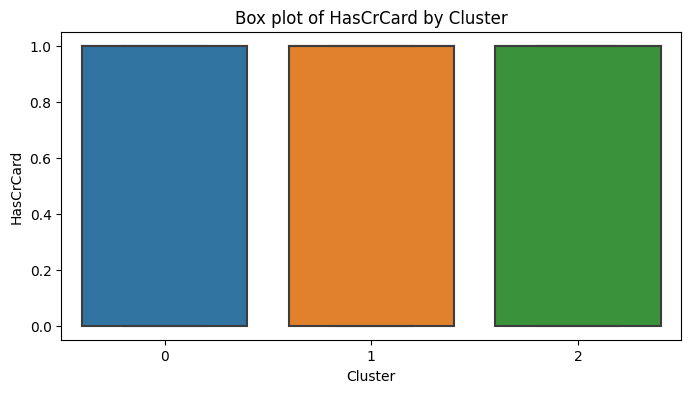

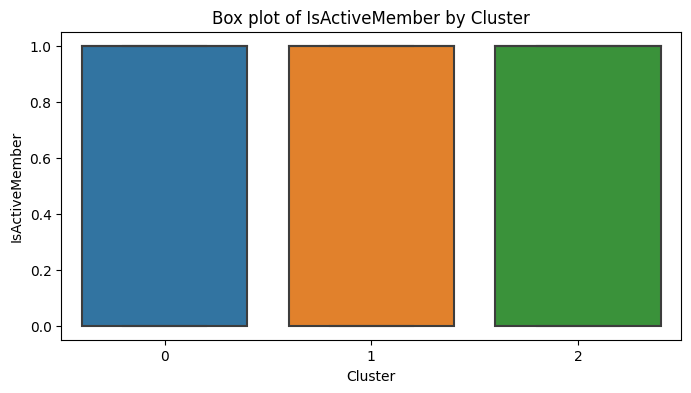

In [165]:
for feature in segmentation_data.columns[:-1]:  # Exclude the 'Cluster' column
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Cluster', y=feature, data=segmentation_data)
    plt.title(f'Box plot of {feature} by Cluster')
    plt.show()

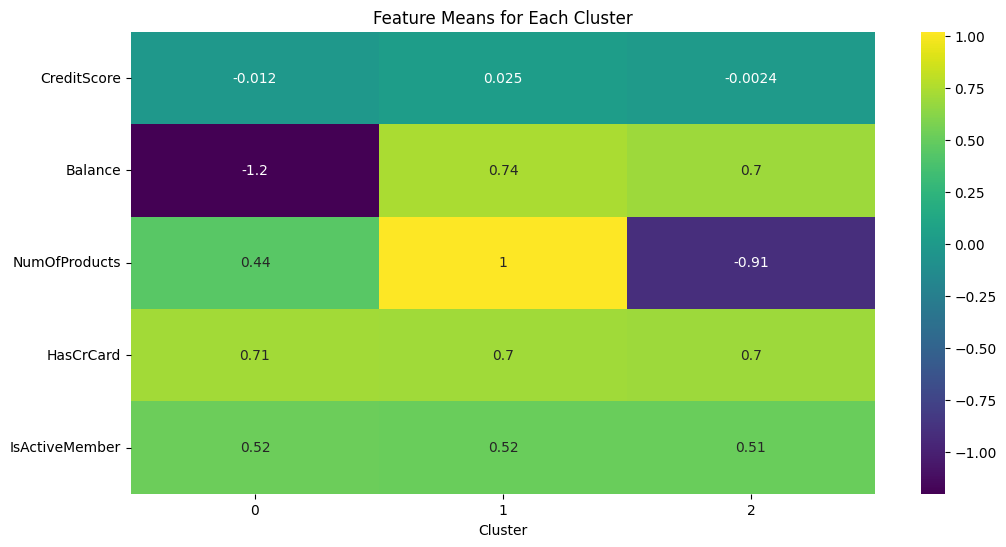

In [166]:
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles.T, annot=True, cmap='viridis')
plt.title('Feature Means for Each Cluster')
plt.show()

In [117]:
df['Balance'].mean()

76481.49081916384

In [118]:
data = df.copy()

In [119]:
def categorize_balance(balance):
    if balance <= 0:
        return 'No Balance'
    elif balance <= 50000:
        return '0 - 50k'
    elif balance <= 100000:
        return '50k - 100k'
    else:
        return 'More than 100k'

data['BalanceBins'] = data['Balance'].apply(categorize_balance)

In [120]:
data['BalanceBins'].value_counts()

BalanceBins
More than 100k    4797
No Balance        3616
50k - 100k        1510
0 - 50k             75
Name: count, dtype: int64

In [121]:
data[data['BalanceBins'] == 'No Balance']['Exited'].value_counts()

Exited
0    3116
1     500
Name: count, dtype: int64

In [122]:
data[data['BalanceBins'] != 'No Balance']['Exited'].value_counts()

Exited
0    4844
1    1538
Name: count, dtype: int64

In [123]:
data['Exited'].value_counts()

Exited
0    7960
1    2038
Name: count, dtype: int64

In [124]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(data['BalanceBins'], data['Exited'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
alpha = 0.05
print("Chi-square statistic:", chi2)
print("p-value:", p)
if p < alpha:
    print("Reject the null hypothesis. There is a significant association between bank balance and churn status.")
else:
    print("Fail to reject the null hypothesis. There is no significant association between bank balance and churn status.")

Chi-square statistic: 175.24191364297803
p-value: 9.395467471392104e-38
Reject the null hypothesis. There is a significant association between bank balance and churn status.
